In [2]:
import joblib
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.model_selection import LeaveOneOut
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
# from envs.filtr_json_from_race import load_from_db
import sqlite3
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
class LSTMStatePredictor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,n_steps_ahead, num_layers=1):
        super(LSTMStatePredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size * n_steps_ahead)
        self.scaler_X = None
        self.scaler_Y = None
        self.n_steps_ahead = n_steps_ahead
        self.output_size = output_size

    def forward(self, x):
        h_0 = torch.zeros(1, x.size(0), self.lstm.hidden_size).to(x.device) #hidden state
        c_0 = torch.zeros(1, x.size(0), self.lstm.hidden_size).to(x.device) #cell state

        out, _ = self.lstm(x, (h_0, c_0))
        # out = self.fc(out[:, -1, :])  # Use the last time step's output
        out = self.fc(out[:, -1, :]).view(-1, self.n_steps_ahead, self.output_size)
        return out

def create_scalers(X,Y):

    cont_indices_x = slice(0, 18)   # continuous columns for X (0–17)
    cont_indices_y = slice(0, 12)   # continuous columns for Y (0–11)

    # Scale continuous features
    flat_x = np.vstack([x[:, cont_indices_x] for x in X])
    flat_y = np.vstack([y[:, cont_indices_y] for y in Y])

    scaler_X = MinMaxScaler().fit(flat_x)
    scaler_Y = MinMaxScaler().fit(flat_y)
    return scaler_X, scaler_Y


def scale_input(X, Y, scaler_X, scaler_Y):
    cont_indices_x = slice(0, 18)   # continuous columns for X
    cont_indices_y = slice(0, 12)   # continuous columns for Y

    X_scaled_grouped = []
    Y_scaled_grouped = []

    for x_seq, y_seq in zip(X, Y):
        x_scaled = np.array(x_seq, dtype=float)
        x_scaled[:, cont_indices_x] = scaler_X.transform(x_seq[:, cont_indices_x])
        X_scaled_grouped.append(x_scaled)

        y_scaled = np.array(y_seq, dtype=float)
        y_scaled[:, cont_indices_y] = scaler_Y.transform(y_seq[:, cont_indices_y])
        Y_scaled_grouped.append(y_scaled)

    # Conversion to torch tensors
    # X_t = [torch.tensor(x, dtype=torch.float32) for x in X_scaled_grouped]
    # Y_cont_t = [torch.tensor(y[:, cont_indices_y], dtype=torch.float32) for y in Y_scaled_grouped]

    return X_scaled_grouped, Y_scaled_grouped

In [4]:
def load_data_from_db():
    
    """
    Load data so that each race is a separate sequence:
    X = [ [state1_race1, state2_race1, ...], [state1_race2, ...] ]
    Y = [ [next1_race1, next2_race1, ...], ... ]
    """
    conn = sqlite3.connect(
        "E:/pracadyp/Race-optimization-reinforcement-learning/data/db_states_for_regress/race_data_states.db"
    )
    cursor = conn.cursor()
    cursor.execute("SELECT race_id, states_json FROM races ORDER BY race_id")
    rows = cursor.fetchall()
    conn.close()


    data = []

    for race_id, states_json in rows:
        states = json.loads(states_json)
        data.append(states)
    
    return data

def create_windows(sequence_x, sequence_y, window_size, n_steps_ahead=5):
    X, Y = [], []
    for t in range(1, len(sequence_x)):
        start = max(0, t - window_size)
        window = sequence_x[start:t]

        # padding na początku, jeśli okno krótsze niż window_size
        pad_len = window_size - len(window)
        if pad_len > 0:
            window = np.vstack([np.zeros((pad_len, sequence_x.shape[1])), window])
        X.append(window)

        # Y: wypełniamy zerami, jeśli końcówka wyścigu ma mniej niż n_steps_ahead
        y_window = sequence_y[t:t+n_steps_ahead]
        if y_window.shape[0] < n_steps_ahead:
            pad = np.zeros((n_steps_ahead - y_window.shape[0], sequence_y.shape[1]))
            y_window = np.vstack([y_window, pad])
        Y.append(y_window)

    return np.array(X), np.array(Y)

def create_x_y(data):
    X_grouped, Y_grouped = [], []

    for race in data:
        X_seq, Y_seq = [], []
        for i in range(len(race) - 1):
            X_seq.append(race[i][:-2])
            Y_seq.append(race[i + 1][:-24])
        
        # dodajemy każdy wyścig osobno
        X_grouped.append(np.array(X_seq, dtype=float))
        Y_grouped.append(np.array(Y_seq, dtype=float))

    return X_grouped, Y_grouped

In [ ]:
data = load_data_from_db()
# input_size = X[0].shape[1]
# output_size = Y[0].shape[1]

X, Y = create_x_y(data)
input_size = X[0].shape[1]
output_size = Y[0].shape[1]

# scaler_X, scaler_Y = create_scalers(X,Y)

# X_scaled, Y_scaled = scale_input(X,Y,scaler_X,scaler_Y)

# X_scaled = [scaler_X.transform(np.array(race)) for race in X]
# Y_scaled = [scaler_Y.transform(np.array(race)) for race in Y]


loo = LeaveOneOut()
all_fold_train = []
all_fold_test = []
all_fold_r2_test = []
i = 0
for fold, (train_idx, test_idx) in enumerate(loo.split(X)):
    i += 1
   

    X_train = [X[i] for i in train_idx]
    X_test  = [X[i] for i in test_idx]
    Y_train = [Y[i] for i in train_idx]
    Y_test  = [Y[i] for i in test_idx]

    scaler_X, scaler_Y = create_scalers(X_train,Y_train)

    X_train, Y_train = scale_input(X_train,Y_train,scaler_X,scaler_Y)
    X_test, Y_test = scale_input(X_test,Y_test,scaler_X,scaler_Y)
    n_steps_ahead = 5  # number of future steps to predict


    all_X, all_Y = [], []
    for race_x, race_y in zip(X_train, Y_train):  
        X_r, Y_r = create_windows(race_x, race_y, window_size=30, n_steps_ahead=n_steps_ahead)
        all_X.append(X_r)
        all_Y.append(Y_r)

    X_train = np.vstack(all_X)  # shape: [N_samples, window_size, n_features]
    Y_train = np.vstack(all_Y) 
    all_X, all_Y = [], []
    for race_x, race_y in zip(X_test, Y_test):  
        X_r, Y_r = create_windows(race_x, race_y, window_size=30)
        all_X.append(X_r)
        all_Y.append(Y_r)
    X_test = np.vstack(all_X)  # shape: [N_samples, window_size, n_features]
    Y_test = np.vstack(all_Y)


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    model = LSTMStatePredictor(input_size=input_size, hidden_size=128, output_size=output_size,n_steps_ahead=n_steps_ahead, num_layers=1).to(device)



    
    
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32).to(device)

    train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=512, shuffle=False)

    optimizer = optim.Adam(model.parameters(), lr=4e-5)
    loss_cont = nn.MSELoss()
    loss_cat  = nn.CrossEntropyLoss()

    fold_train_losses = []
    fold_test_losses = []
    num_epochs = 250
    all_r2_per_output = []
    fold_r2_scores = []
    
    for epoch in range(num_epochs):
        
        model.train()
        total_loss = 0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            pred = model(x_batch)
            loss = loss_cont(pred, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        fold_train_losses.append(total_loss / len(train_loader))

        model.eval()
        with torch.no_grad():
            pred_test = model(X_test_tensor)
            test_loss = loss_cont(pred_test, Y_test_tensor).item()
            fold_test_losses.append(test_loss)
            
            if epoch == num_epochs - 1:
                b, t, f = pred_test.shape
                pred_test_flat = pred_test.cpu().numpy().reshape(b*t, f)
                Y_test_flat = Y_test_tensor.cpu().numpy().reshape(b*t, f)

                # inverse transform
                pred_test_inv = scaler_Y.inverse_transform(pred_test_flat)
                Y_test_inv = scaler_Y.inverse_transform(Y_test_flat)

                # R² po cechach
                r2s = [r2_score(Y_test_inv[:, i], pred_test_inv[:, i]) for i in range(f)]
                avg_r2_per_output = np.mean(r2s)
                print("Avg R2 per output:", r2s)
                print("Mean R2:", avg_r2_per_output)
        
    plt.figure()
    plt.plot(fold_train_losses, label='Train')
    plt.plot(fold_test_losses, label='Test')
    plt.title(f'Fold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    if i == 1:
        break

                # opcjonalnie: wróć do kształtu 3D, jeśli chcesz generować sekwencje
                # pred_test_inv = pred_test_inv.reshape(b, t, f)
                # Y_test_inv    = Y_test_inv.reshape(b, t, f)


        
    # all_fold_train.append(fold_train_losses)
    # all_fold_test.append(fold_test_losses)
    # # all_fold_r2.append(fold_r2_scores)

    # # Compute R^2 score for the test set
    # r2 = r2_score(Y_test_tensor.cpu().numpy(), pred_test.cpu().numpy())
    # all_fold_r2_test.append(r2)


In [ ]:
def create_window_pred(sequence_x, window_size, n_steps_ahead=5):
    X, Y = [], []
    curr_len = len(sequence_x)

    # for t in range(1, len(sequence_x)):
    start = max(0, curr_len - window_size)
    window = sequence_x[start:curr_len]

    # padding na początku, jeśli okno krótsze niż window_size
    pad_len = window_size - len(window)
    if pad_len > 0:
        window = np.vstack([np.zeros((pad_len, sequence_x.shape[1])), window])
    X.append(window)

        

    return np.array(X)

Generate state predictions

In [ ]:
del X_train_tensor, Y_train_tensor, X_test_tensor, Y_test_tensor
window_size = 30
X_init = X_test[0]  
print(X_init)  # skalowane
# current_window = torch.tensor(X_init, dtype=torch.float32).unsqueeze(0).to(device)
race_states = []
race_states.append(X_init)
current_window = create_window_pred(race_states,window_size=window_size)
current_window = torch.tensor(current_window, dtype=torch.float32).to(device)
model.eval()
for _ in range(1000):
    with torch.no_grad():
        pred_test = model(current_window)
        print(pred_test)
        
        race_states.append(pred_test.cpu().numpy())
        current_window = create_window_pred(race_states, window_size=window_size)
        current_window = torch.tensor(current_window, dtype=torch.float32).to(device)

        pred_test_inv = scaler_Y.inverse_transform(pred_test.cpu().numpy())
        Y_test_inv = scaler_Y.inverse_transform(current_window.squeeze(0).cpu().numpy())



In [ ]:
# num_features = y_cont_orig.shape[1]
# plt.figure(figsize=(15, 3 * num_features))
# titles = ['Lap progress','Race progress', 'Fuel level', 'Wheel1 wear', 'Wheel2 wear', 'Wheel3 wear', 'Wheel4 wear', 'Wheel1 temp','Wheel2 temp','Wheel3 temp','Wheel4 temp','AvgPathWetness']
# for i in range(num_features):
#     plt.subplot(num_features, 1, i + 1)
#     plt.plot(y_cont_orig[:, i], label='Rzeczywiste')
#     plt.plot(cont_pred_orig[:, i], label='Predykcja', linestyle='--')
#     plt.title(f'{titles[i]}')
#     plt.legend()



# plt.tight_layout()
# plt.show()

In [ ]:
del model, X_train_tensor, Y_train_tensor, X_test_tensor, Y_test_tensor
torch.cuda.empty_cache()

Visualize var to generate by alghoritm(weather,damages,itd)

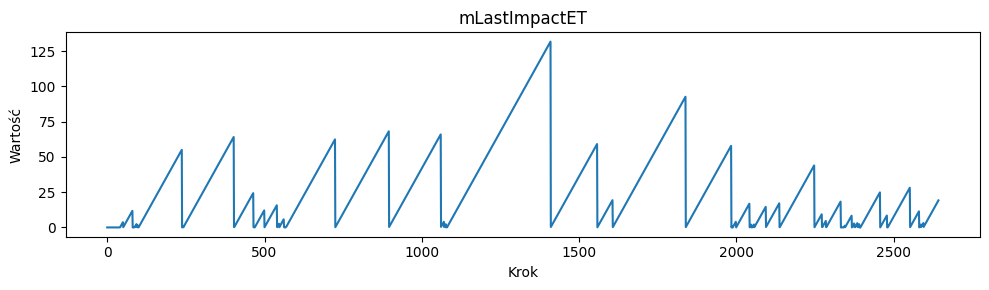

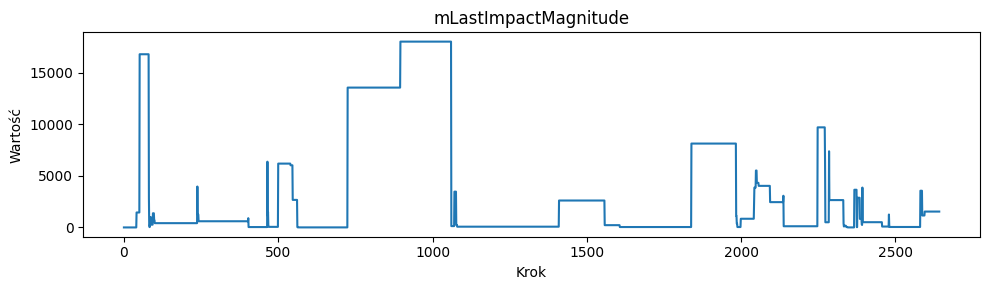

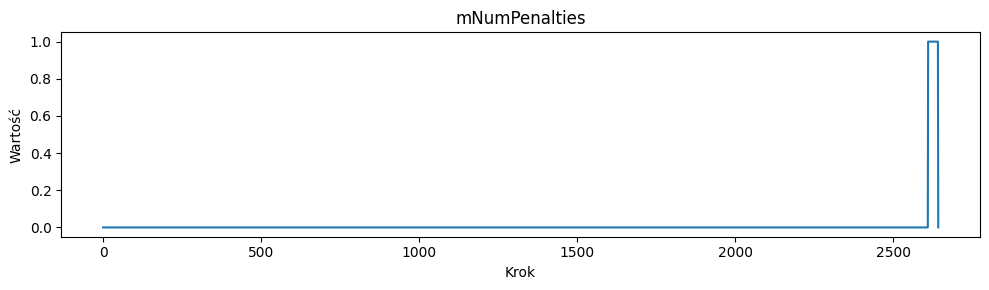

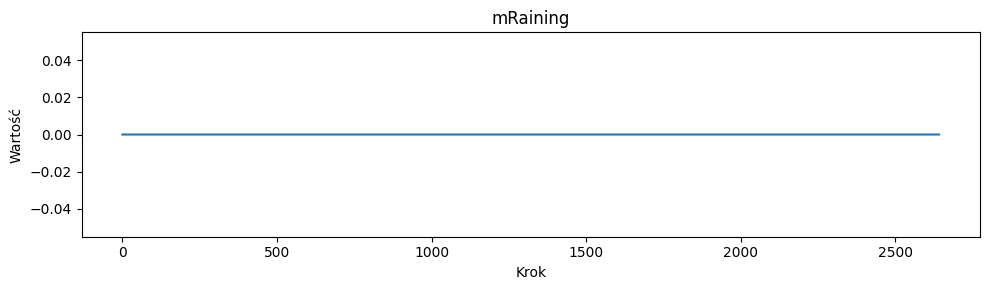

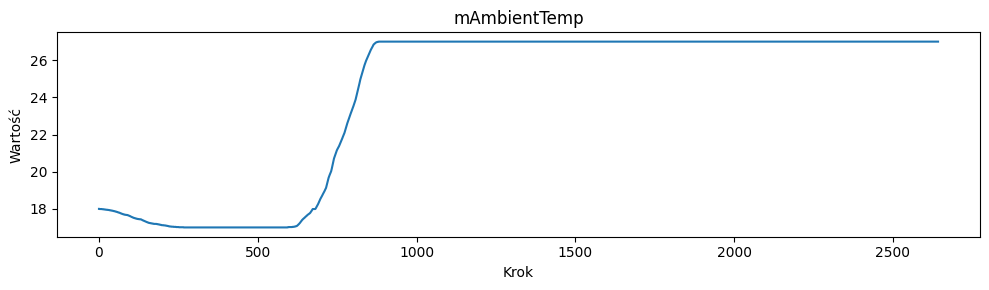

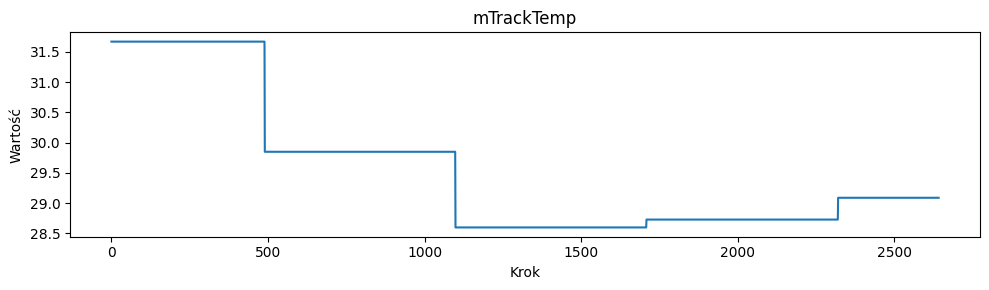

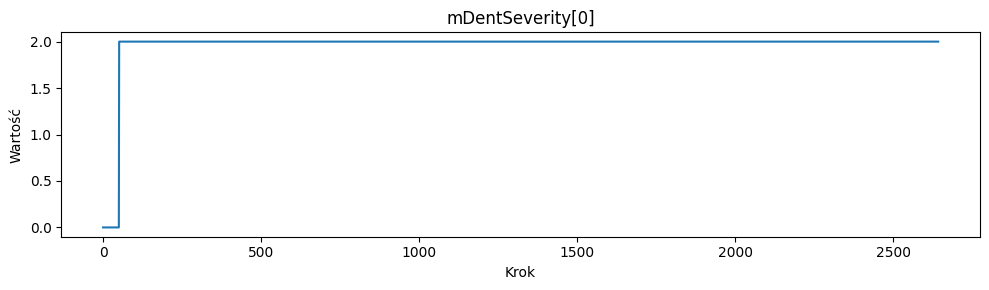

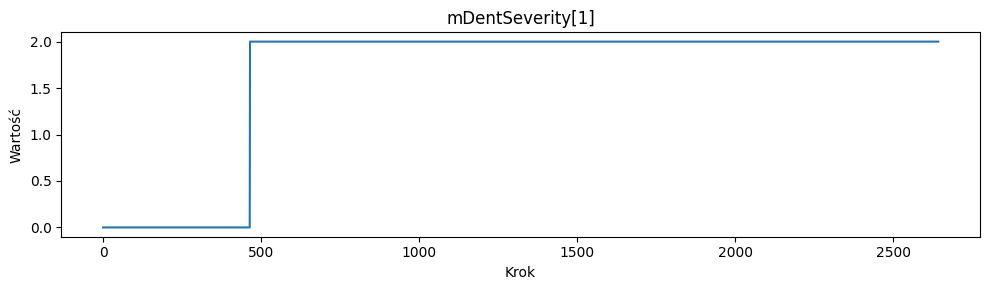

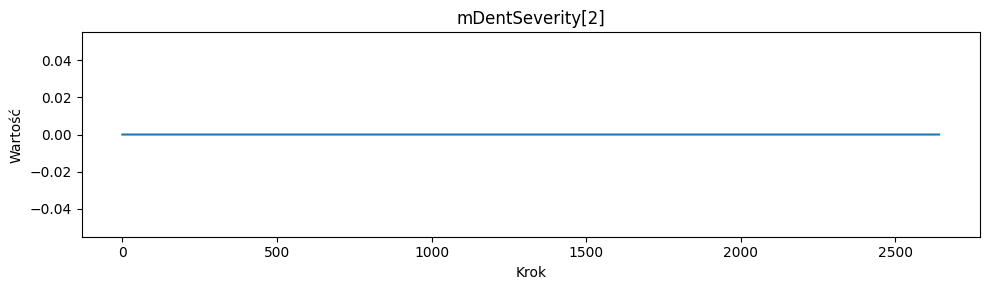

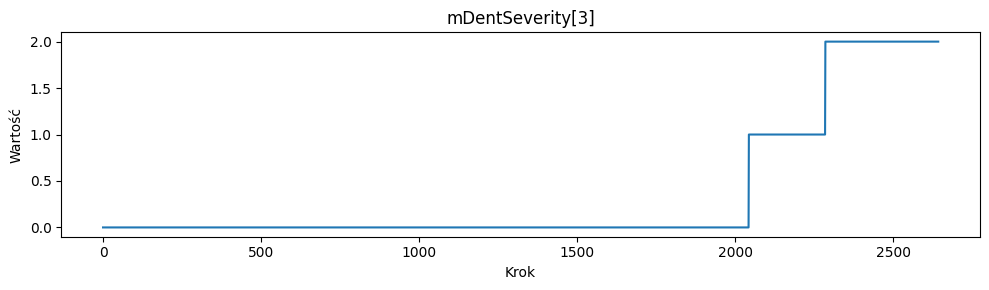

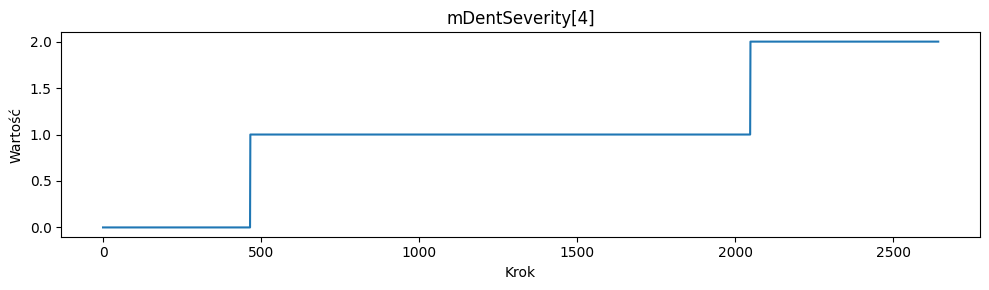

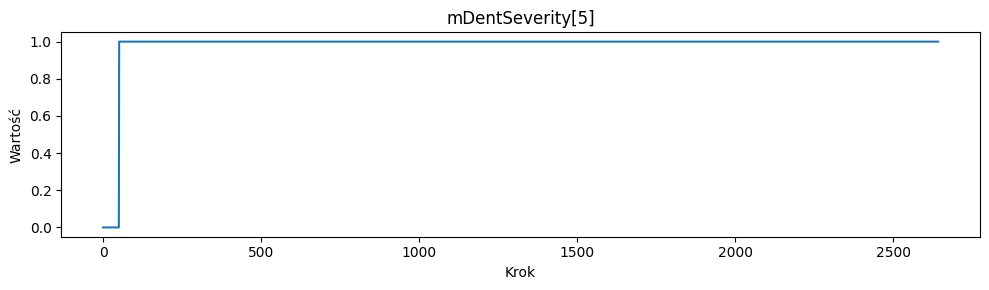

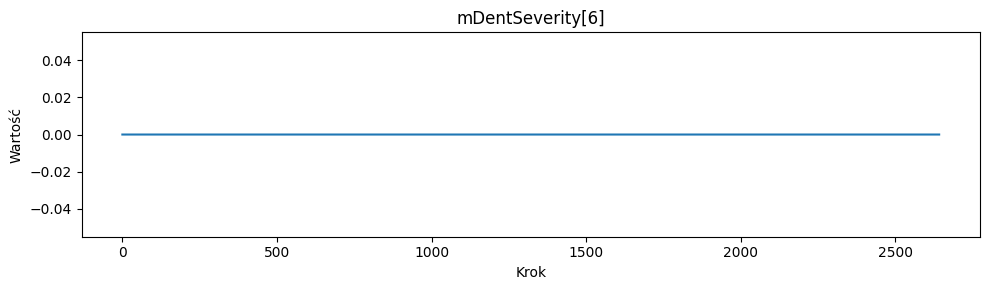

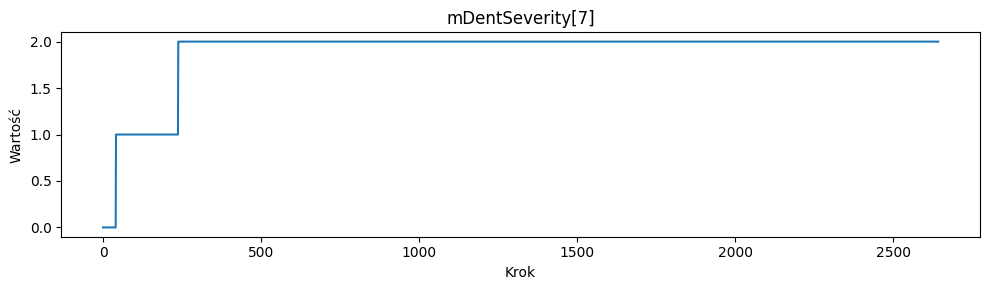

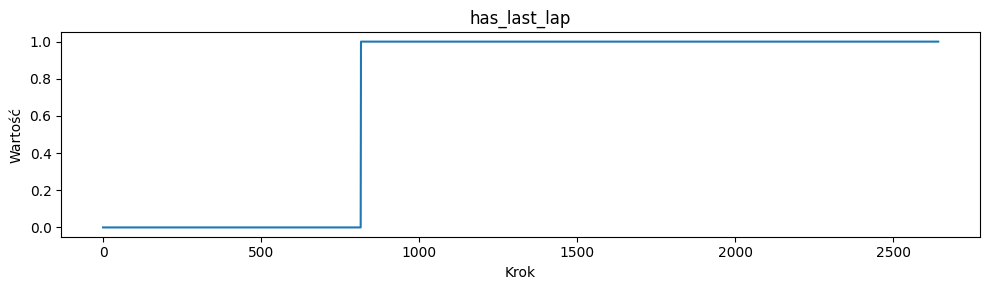

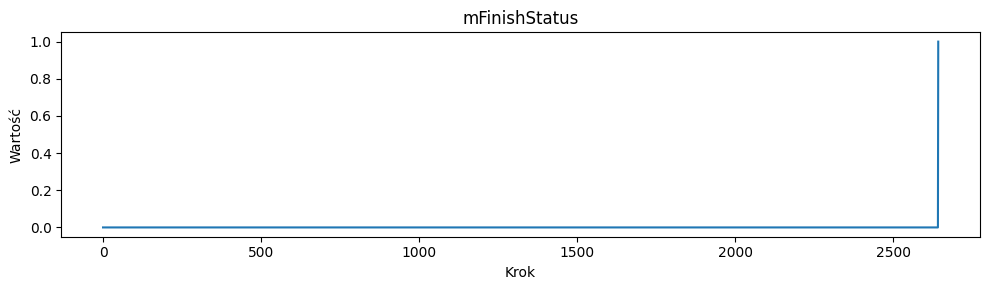

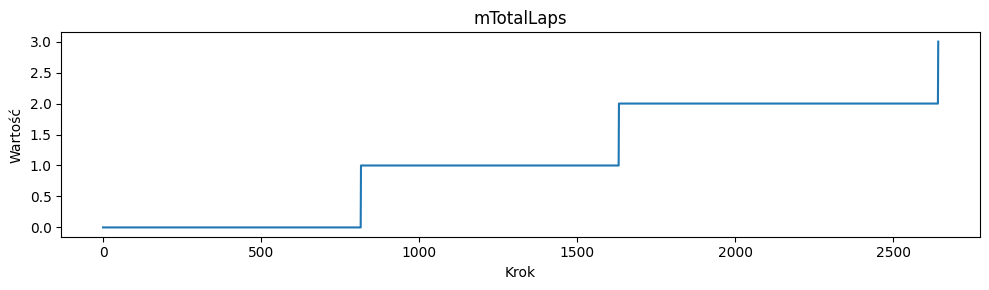

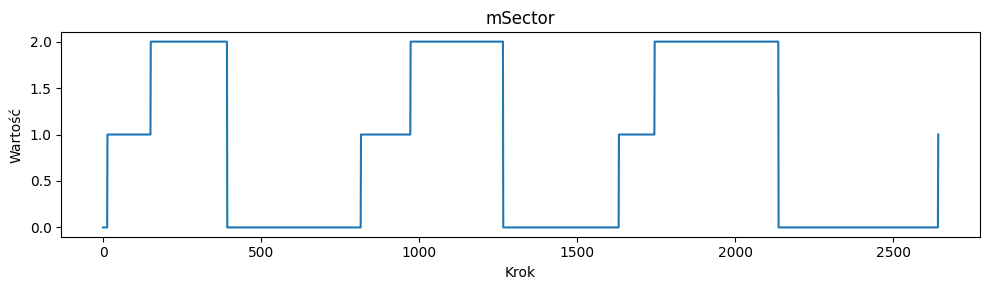

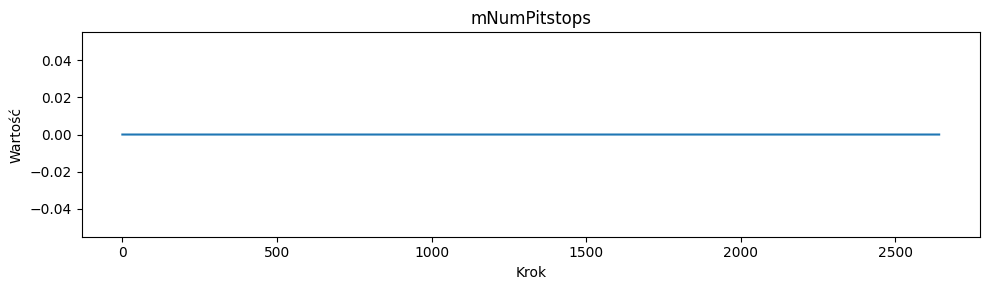

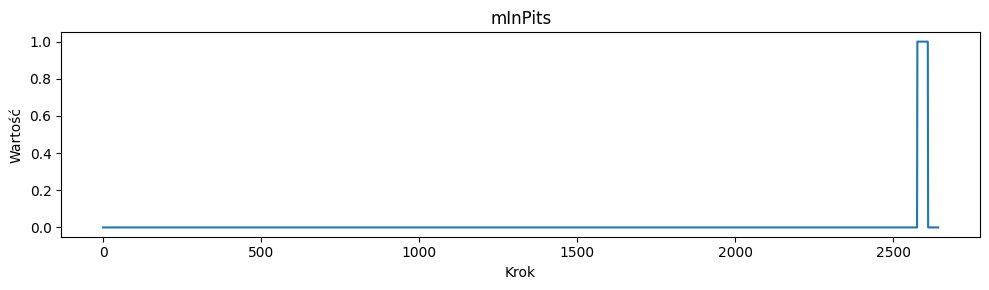

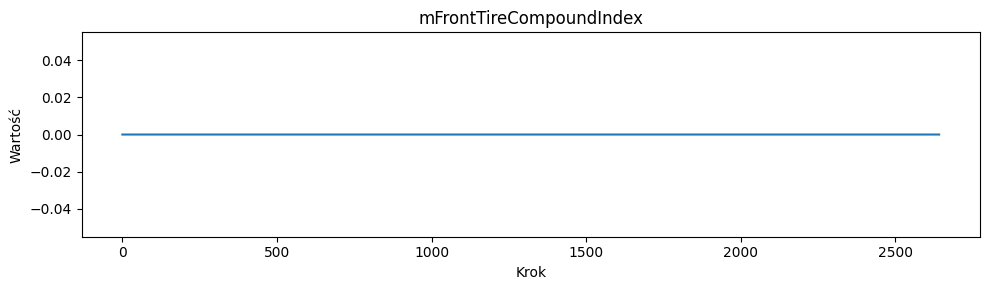

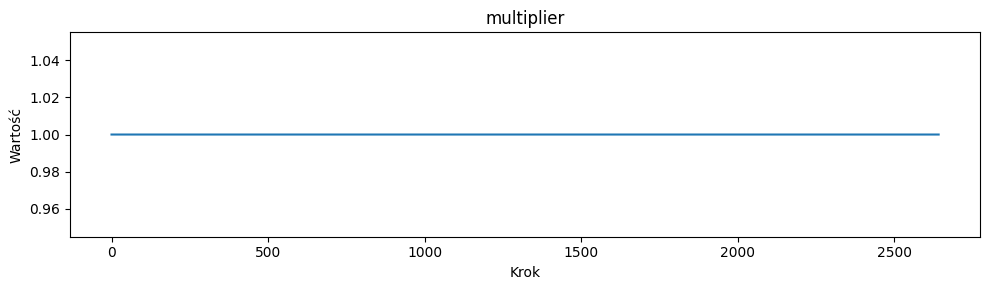

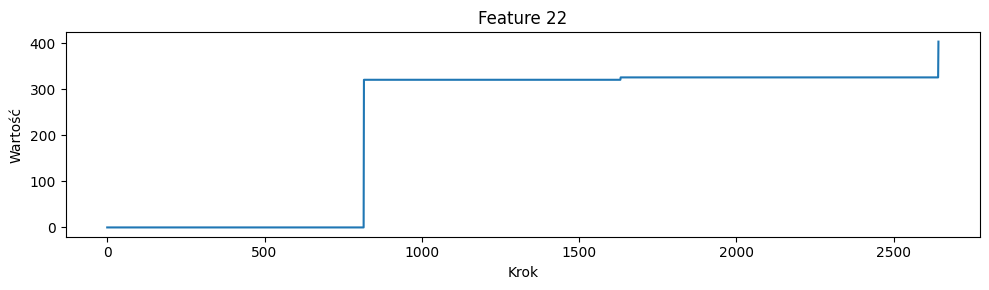

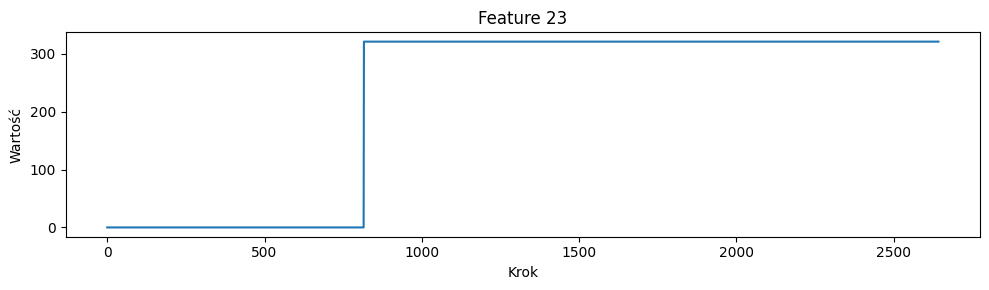

mLastImpactET: min=-0.01229, max=1.0001
mLastImpactMagnitude: min=-0.0, max=1.61555
mNumPenalties: min=0.01071, max=0.81818
mRaining: min=0.02252, max=1.0
mAmbientTemp: min=0.00099, max=1.0
mTrackTemp: min=0.46473, max=1.0
mDentSeverity[0]: min=0.49453, max=1.0
mDentSeverity[1]: min=0.0, max=556.16067
mDentSeverity[2]: min=0.0, max=533.7546
mDentSeverity[3]: min=0.0, max=561.80517
mDentSeverity[4]: min=0.0, max=539.95143
mDentSeverity[5]: min=0.0, max=1.0
mDentSeverity[6]: min=0.0, max=844.02001953125
mDentSeverity[7]: min=0.0, max=22007.326171875
has_last_lap: min=0.0, max=1.0
mFinishStatus: min=0.0, max=1.0
mTotalLaps: min=5.33, max=40.0
mSector: min=9.0, max=47.35
mNumPitstops: min=0.0, max=2.0
mInPits: min=0.0, max=2.0
mFrontTireCompoundIndex: min=0.0, max=0.0
multiplier: min=0.0, max=2.0
Feature 22: min=0.0, max=2.0
Feature 23: min=0.0, max=2.0


IndexError: list index out of range

In [ ]:
# Nazwy cech według Twojego opisu
feature_names = [
    "mLastImpactET",
    "mLastImpactMagnitude",
    "mNumPenalties",
    "mRaining",
    "mAmbientTemp",
    "mTrackTemp",
    "mDentSeverity[0]",
    "mDentSeverity[1]",
    "mDentSeverity[2]",
    "mDentSeverity[3]",
    "mDentSeverity[4]",
    "mDentSeverity[5]",
    "mDentSeverity[6]",
    "mDentSeverity[7]",
    "has_last_lap",
    "mFinishStatus",
    "mTotalLaps",
    "mSector",
    "mNumPitstops",
    "mInPits",
    "mFrontTireCompoundIndex",
    "multiplier"
]

# Jeśli masz mniej niż 24 nazw, dodaj puste lub dopisz brakujące
while len(feature_names) < 24:
    feature_names.append(f"Feature {len(feature_names)}")

data = load_data_from_db()
race = np.array(data[1])  # pierwszy wyścig
last_24_features = race[:, -24:]  # shape: [liczba_kroków, 24]

for i in range(24):
    plt.figure(figsize=(10, 3))
    plt.plot(last_24_features[:, i])
    plt.title(f"{feature_names[i]}")
    plt.xlabel("Krok")
    plt.ylabel("Wartość")
    plt.tight_layout()
    plt.show()

data = load_data_from_db()
num_features = 24

# Inicjalizacja list na min i max dla każdej cechy
feature_mins = [float('inf')] * num_features
feature_maxs = [float('-inf')] * num_features

for race in data:
    race = np.array(race)
    last_24_features = race[:, -num_features:]  # shape: [liczba_kroków, 24]
    for i in range(num_features):
        feature_min = np.min(last_24_features[:, i])
        feature_max = np.max(last_24_features[:, i])
        if feature_min < feature_mins[i]:
            feature_mins[i] = feature_min
        if feature_max > feature_maxs[i]:
            feature_maxs[i] = feature_max

for i in range(num_features):
    print(f"{feature_names[i]}: min={feature_mins[i]}, max={feature_maxs[i]}")






In [14]:
race = np.array(data[0])  # pierwszy wyścig

lap_distance = race[:, 0]  # podaj właściwy indeks dystansu okrążenia
sector = race[:, 29]
print("Unikalne sektory:", np.unique(sector))

for i in range(1, len(race)):
    if sector[i] != sector[i-1]:
        print(f"Sektor zmienił się na {sector[i]} przy dystansie {lap_distance[i]}")

Unikalne sektory: [0. 1. 2.]
Sektor zmienił się na 1.0 przy dystansie -0.01213
Sektor zmienił się na 2.0 przy dystansie 0.13955
Sektor zmienił się na 0.0 przy dystansie 0.5677
Sektor zmienił się na 1.0 przy dystansie 0.00034
Sektor zmienił się na 2.0 przy dystansie 0.14061
Sektor zmienił się na 0.0 przy dystansie 0.56768
Sektor zmienił się na 1.0 przy dystansie 0.00111


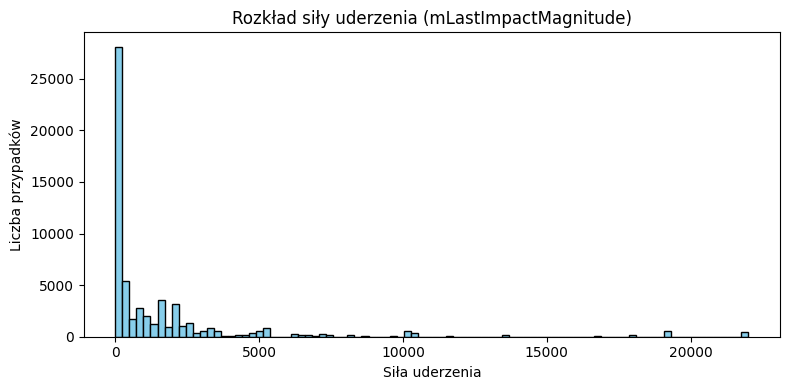

Bin edges: [    0.           244.52584635   489.05169271   733.57753906
   978.10338542  1222.62923177  1467.15507813  1711.68092448
  1956.20677083  2200.73261719  2445.25846354  2689.7843099
  2934.31015625  3178.8360026   3423.36184896  3667.88769531
  3912.41354167  4156.93938802  4401.46523438  4645.99108073
  4890.51692708  5135.04277344  5379.56861979  5624.09446615
  5868.6203125   6113.14615885  6357.67200521  6602.19785156
  6846.72369792  7091.24954427  7335.77539062  7580.30123698
  7824.82708333  8069.35292969  8313.87877604  8558.4046224
  8802.93046875  9047.4563151   9291.98216146  9536.50800781
  9781.03385417 10025.55970052 10270.08554687 10514.61139323
 10759.13723958 11003.66308594 11248.18893229 11492.71477865
 11737.240625   11981.76647135 12226.29231771 12470.81816406
 12715.34401042 12959.86985677 13204.39570313 13448.92154948
 13693.44739583 13937.97324219 14182.49908854 14427.0249349
 14671.55078125 14916.0766276  15160.60247396 15405.12832031
 15649.65416667 

In [17]:
impact_magnitudes = []

for race in data:
    race = np.array(race)
    # Zakładam, że mLastImpactMagnitude to jedna z ostatnich 24 cech, np. indeks 1
    impact_magnitudes.extend(race[:, -23])  # -23 jeśli to druga cecha z końca, popraw jeśli inny indeks

impact_magnitudes = np.array(impact_magnitudes)

plt.figure(figsize=(8, 4))
plt.hist(impact_magnitudes, bins=90, color='skyblue', edgecolor='black')
plt.title("Rozkład siły uderzenia (mLastImpactMagnitude)")
plt.xlabel("Siła uderzenia")
plt.ylabel("Liczba przypadków")
plt.tight_layout()
plt.show()


# Zbierz wszystkie wartości siły uderzenia
impact_magnitudes = []
for race in data:
    race = np.array(race)
    impact_magnitudes.extend(race[:, -23])  # -23 jeśli to druga cecha z końca

impact_magnitudes = np.array(impact_magnitudes)

# Policz histogram (np. 20 przedziałów)
hist, bin_edges = np.histogram(impact_magnitudes, bins=90, density=True)
print("Bin edges:", bin_edges)
probabilities = hist / hist.sum()  # prawdopodobieństwa dla każdego przedziału
print(probabilities)

np.save('E:/pracadyp/Race-optimization-reinforcement-learning/data/probabilities_impact/probabilities.npy', probabilities)
np.save('E:/pracadyp/Race-optimization-reinforcement-learning/data/probabilities_impact/bin_edges.npy', bin_edges)


In [ ]:
data = load_data_from_db()
num_features = 36

# Inicjalizacja list na min i max dla każdej cechy
feature_mins = [float('inf')] * num_features
feature_maxs = [float('-inf')] * num_features

for race in data:
    race = np.array(race)
    all_features = race[:, -num_features:]  # shape: [liczba_kroków, 36]
    for i in range(num_features):
        feature_min = np.min(all_features[:, i])
        feature_max = np.max(all_features[:, i])
        if feature_min < feature_mins[i]:
            feature_mins[i] = feature_min
        if feature_max > feature_maxs[i]:
            feature_maxs[i] = feature_max

for i in range(num_features):
    print(f": min={feature_mins[i]}, max={feature_maxs[i]}")

IndexError: index 36 is out of bounds for axis 1 with size 36